# PFA dataset Classifier

Objective: Build classifiers for severity, category and classification given that we have utterances.

In [1]:
import enchant
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
from collections import Counter
import re

from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from string import punctuation

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Input, CuDNNLSTM,GlobalMaxPool1D, Embedding, Dropout, Activation, SpatialDropout1D, Bidirectional
from keras.layers.merge import concatenate
from keras.models import Model
from keras.layers.normalization import BatchNormalization
from keras.callbacks import EarlyStopping, ModelCheckpoint,ReduceLROnPlateau
from keras.optimizers import RMSprop, nadam, adam
from keras.utils import np_utils

%matplotlib inline

/home/mukesh/miniconda3/envs/statoil/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


# Loading Dataset


In [2]:
path='data/'
train=path+'train_CD.csv'

embedding_file=path+'wiki.en.vec' #fasttext word embeddings
max_words=100000
max_seq_len=60
embedding_dim=300

num_gru = 128
num_dense = 64
rate_drop_dense = 0.3

In [3]:
data=pd.read_csv(train)
data.head()

/home/mukesh/miniconda3/envs/statoil/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2728: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,Description,Classification,Category,Severity
0,** PROBLEM Service Alert: USSGWIFIMGMT001/USDA...,8.0,"1,225",3
1,Please Collect ID Card/Access Card for - Rachn...,1.0,"1,451",NaN
2,Install 32-bit TortoiseSVN on my machine,1.0,970,4
3,Tubelight above the cubical is not working. Pl...,10.0,174,12
4,Require Toner,1.0,920,4


In [4]:
len(data)

263394

In [5]:
print("Null values")
data.isnull().sum()

Null values


Description         85
Classification     672
Category           655
Severity          2320
dtype: int64

In [6]:
data=data.dropna()
len(data)

260910

In [7]:
data["Classification"].describe()

count    260910.000000
mean         36.381315
std          47.741645
min           1.000000
25%           1.000000
50%           8.000000
75%         109.000000
max         173.000000
Name: Classification, dtype: float64

In [8]:
data["Category"].describe()

count     260910
unique       719
top        1,148
freq       18104
Name: Category, dtype: object

In [9]:
data["Severity"].describe()

count     260910
unique        45
top            4
freq      117673
Name: Severity, dtype: object

In [10]:
# There are few values in classification column having commas e.g 1,234
# we need to convert it to int or float
def remove_comma(arr):
    new_arr=[]
    for p in arr:
        try:
            q=p.split(',')
            #print(q)
            q=''.join(q)
            new_arr.append(q)
        except:
            new_arr.append(p)
    return new_arr

In [11]:
data["Category"]=remove_comma(data["Category"].values)
data["Severity"]=remove_comma(data["Severity"].values)

In [12]:
data["Severity"]=data["Severity"].astype(np.float64)
data["Category"]=data["Category"].astype(np.float64)

In [13]:
data.describe()

,Classification,Category,Severity
count,260910.000000,260910.000000,260910.000000
mean,36.381315,768.815948,5.141681
std,47.741645,416.174000,5.639528
min,1.000000,1.000000,1.000000
25%,1.000000,323.000000,3.000000
50%,8.000000,926.000000,4.000000
75%,109.000000,1083.000000,4.000000
max,173.000000,2466.000000,1095.000000


In [14]:
lens=data.Description.str.len()
lens.mean(), lens.std(), lens.max()

(46.98753976466981, 28.361221781943883, 270)

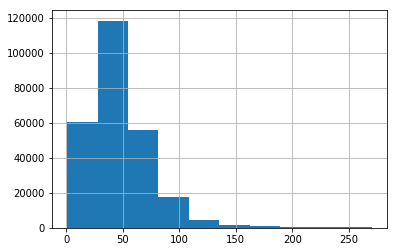

In [15]:
lens.hist()

In [16]:
lens.describe()

count    260910.000000
mean         46.987540
std          28.361222
min           1.000000
25%          29.000000
50%          40.000000
75%          62.000000
max         270.000000
Name: Description, dtype: float64

<Container object of 65 artists>

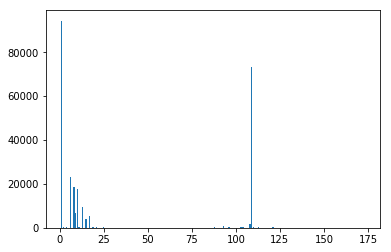

In [17]:
classi = Counter(data['Classification'])
plt.bar(classi.keys(),classi.values())

<Container object of 719 artists>

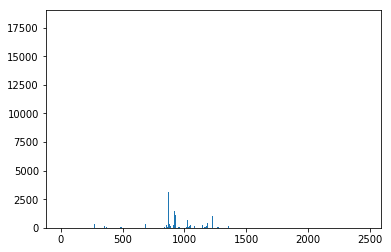

In [18]:
cat = Counter(data['Category'])
plt.bar(cat.keys(),cat.values())

In [19]:
list_classes=['Classification','Category','Severity']
nb_classification_label = len(set(data['Classification']))
nb_category_label = len(set(data['Category']))

print("classification labels ", nb_classification_label)
print("category labels ", nb_category_label)

classification labels  65
category labels  719


# Few insights from the dataset
The dataset contains 4 columns:

Description: contains text/complaints. Length varies from 1 to 270

Classification: It has 65 different labels

Category: There are 719 categories

Severity: This column contains continuous values, denoting the severity of issue mentioned in description

In [20]:
#Splitting the dataset
train_x, test_x, train_y, test_y = train_test_split(data['Description'],data[list_classes], test_size=0.2, random_state=2)
print("train", train_x.shape, train_y.shape)
print("test", test_x.shape, test_y.shape)

train (208728,) (208728, 3)
test (52182,) (52182, 3)


In [21]:
print('Indexing word vectors')

#Glove Vectors
embeddings_index = {}
f = open(embedding_file)
for line in f:
    values = line.split()
    word = ' '.join(values[:-300])
    coefs = np.asarray(values[-300:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Total %s word vectors.' % len(embeddings_index))

Indexing word vectors
Total 2518927 word vectors.


In [22]:
class SpellingReplacer(object):
    def __init__(self, dict_name='en', max_dist=2):
        self.spell_dict = enchant.Dict(dict_name)
        self.max_dist = max_dist
    def replace(self, word):
        if self.spell_dict.check(word):
            return word
        suggestions = self.spell_dict.suggest(word)
        if suggestions and edit_distance(word, suggestions[0]) <=self.max_dist:
            return suggestions[0]
        else:
            return word

In [23]:
print('Processing text dataset')

#Regex to remove all Non-Alpha Numeric and space
special_character_removal=re.compile(r'[^a-z\d ]',re.IGNORECASE)

#regex to replace all numerics
replace_numbers=re.compile(r'\d+',re.IGNORECASE)

#regex to replace ip address
replace_ip=re.compile(r'([0-9]+)(?:\.[0-9]+){3}',)

#replace_url
url_regex = re.compile(r"(http|https|ftp)://[a-zA-Z0-9\./]+")

def text_to_wordlist(text, remove_stopwords=True, stem_words=False, spell_correct=False):
    # Clean the text, with the option to remove stopwords and to stem words.
    
    #remove urls
    text=url_regex.sub("",text)
    
    # Convert words to lower case and split them
    text = text.lower().split()
    
    
    # Optionally, remove stop words
    if remove_stopwords:
        stops = set(stopwords.words("english"))
        text = [w for w in text if not w in stops]
    
    #Optionally, correct misspelled words, It takes lots of time
    #replacer = SpellingReplacer()
    #if spell_correct:
    #    text=[replacer.replace(w) if w not in embeddings_index.keys() else w for w in text]
        
    text = " ".join(text)
    
    #Replace IP address
    text=replace_ip.sub('',text)
    
    #Remove Special Characters
    text=special_character_removal.sub(' ',text)
    
    
    #Replace Numbers
    text=replace_numbers.sub('',text)
    
    
    # Optionally, shorten words to their stems
    if stem_words:
        text = text.split()
        stemmer = SnowballStemmer('english')
        stemmed_words = [stemmer.stem(word) for word in text]
        text = " ".join(stemmed_words)
    
    # Return a list of words
    return(text)

Processing text dataset


In [24]:
description = []
for text in train_x:
    description.append(text_to_wordlist(text))
    
test_description=[]
for text in test_x:
    test_description.append(text_to_wordlist(text))

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(description+test_description)

sequences = tokenizer.texts_to_sequences(description)
test_sequences = tokenizer.texts_to_sequences(test_description)

word_index = tokenizer.word_index
print('Found %s unique tokens' % len(word_index))

Found 31295 unique tokens


In [25]:
train_x = pad_sequences(sequences, maxlen=max_seq_len)
test_x = pad_sequences(test_sequences, maxlen=max_seq_len)

print('Shape of data tensor:', train_x.shape)
print('Shape of label tensor:', train_y.shape)

print('Shape of test_data tensor:', test_x.shape)
print('Shape of label tensor:', test_y.shape)

Shape of data tensor: (208728, 60)
Shape of label tensor: (208728, 3)
Shape of test_data tensor: (52182, 60)
Shape of label tensor: (52182, 3)


As we have diffent types of predictions: 
1. Categorical: a) Classification b) Category
2. Continuous: a) Severity

We need two type of model for this, one for regression and one for classification

Also in categorical both `Classification` and `Category` has different number of labels, so we need to train them separately.

First, We need to Encode these labels and then convert it to one hot encodings.

In [26]:
def to_OHE(label,nb_classes):
    L_enc = LabelEncoder()
    L_enc.fit(label)
    return np_utils.to_categorical(L_enc.transform(label), nb_classes)

def inverse_OHE(label,encoded_labels,nb_classes):
    decoded=encoded_labels.argmax(1)
    L_enc = LabelEncoder()
    L_enc.fit(label)
    return L_enc.inverse_transform(decoded)

In [27]:
# convert class vectors to binary class matrices
train_classify = to_OHE(train_y['Classification'], nb_classification_label)
train_category = to_OHE(train_y['Category'], nb_category_label)
train_severity = train_y['Severity']

test_classify = to_OHE(test_y['Classification'], nb_classification_label)
test_category = to_OHE(test_y['Category'], nb_category_label)
test_severity = test_y['Severity']

In [28]:
from numpy.random import normal
print('Preparing embedding matrix')
nb_words = min(max_words, len(word_index))
embedding_matrix = np.zeros((nb_words, embedding_dim))
for word, i in word_index.items():
    if i >= max_words:
        continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        try:
            embedding_matrix[i] = embedding_vector
        except:
            continue
    else:
        try:
            embedding_matrix[i] = normal(scale=0.6, size=(embedding_dim,))
        except:
            continue
        
print('Null word embeddings: %d' % np.sum(np.sum(embedding_matrix, axis=1) == 0))

Preparing embedding matrix
Null word embeddings: 1


# Creating Model

In [29]:
def regression_model():
    embedding_layer = Embedding(nb_words,
        embedding_dim,
        weights=[embedding_matrix],
        input_length=max_seq_len,
        trainable=False)


    descriptions = Input(shape=(max_seq_len,), dtype='int32')
    
    embedded_sequences= embedding_layer(descriptions)
    embedded_sequences = BatchNormalization()(embedded_sequences)
    embedded_sequences = SpatialDropout1D(0.2)(embedded_sequences)
    
    x = Bidirectional(CuDNNLSTM(num_gru, return_sequences=True,kernel_initializer='glorot_uniform'))(embedded_sequences)
    x = Bidirectional(CuDNNLSTM(num_gru, return_sequences=True,kernel_initializer='glorot_uniform'))(x)
    x = GlobalMaxPool1D()(x)
    x = Dropout(rate_drop_dense)(x)
    
    x = Dense(num_dense, activation='relu')(x)
    x = Dropout(rate_drop_dense)(x)
    
    x = Dense(num_dense, activation='relu')(x)
    x = Dropout(rate_drop_dense)(x)
    
    preds = Dense(1,activation='relu')(x)
    
    model = Model(inputs=descriptions,outputs=preds)
    model.compile(loss='mean_absolute_error',optimizer=nadam(lr=0.001),metrics=['accuracy'])
    
    return model

def classification_model(nb_classes):
    embedding_layer = Embedding(nb_words,
        embedding_dim,
        weights=[embedding_matrix],
        input_length=max_seq_len,
        trainable=False)

    descriptions = Input(shape=(max_seq_len,), dtype='int32')
    
    embedded_sequences= embedding_layer(descriptions)
    embedded_sequences = BatchNormalization()(embedded_sequences)
    embedded_sequences = SpatialDropout1D(0.3)(embedded_sequences)
    
    x = Bidirectional(CuDNNLSTM(64, return_sequences=True,kernel_initializer='glorot_uniform'))(embedded_sequences)
    x = GlobalMaxPool1D()(x)
    x = Dropout(rate_drop_dense)(x)
    
    x = Dense(32, activation='relu')(x)
    x = Dropout(rate_drop_dense)(x)
    
    preds = Dense(nb_classes,activation='sigmoid')(x)
    
    model = Model(inputs=descriptions,outputs=preds)
    model.compile(loss='binary_crossentropy',optimizer=nadam(lr=0.001),metrics=['accuracy'])
    
    return model

# Training and Testing

In [30]:
regressor = regression_model()
early_stopping =EarlyStopping(monitor='val_loss', patience=9)
bst_regressor = 'regressor_weights.h5'
regressor_checkpoint = ModelCheckpoint(bst_regressor, save_best_only=True, save_weights_only=True)

hist_r = regressor.fit(train_x, train_severity,validation_split=0.2,epochs=100, batch_size=256, shuffle=True,callbacks=[regressor_checkpoint,early_stopping])
bst_val_score_r = min(hist_r.history['val_loss'])
print('minimum mean absolute error',bst_val_score_r)

Train on 166982 samples, validate on 41746 samples
Epoch 1/100
166982/166982 [==============================] - 75s 451us/step - loss: 1.4861 - acc: 0.4293 - val_loss: 0.9132 - val_acc: 0.7387
Epoch 2/100
166982/166982 [==============================] - 74s 446us/step - loss: 1.1934 - acc: 0.5507 - val_loss: 0.9724 - val_acc: 0.7302
Epoch 3/100
166982/166982 [==============================] - 74s 440us/step - loss: 1.1039 - acc: 0.6285 - val_loss: 0.8590 - val_acc: 0.7379
Epoch 4/100
166982/166982 [==============================] - 74s 442us/step - loss: 1.0466 - acc: 0.6683 - val_loss: 0.7955 - val_acc: 0.7585
Epoch 5/100
166982/166982 [==============================] - 74s 444us/step - loss: 1.0066 - acc: 0.6925 - val_loss: 0.8707 - val_acc: 0.7302
Epoch 6/100
166982/166982 [==============================] - 75s 447us/step - loss: 0.9634 - acc: 0.7152 - val_loss: 0.7782 - val_acc: 0.7808
Epoch 7/100
166982/166982 [==============================] - 75s 448us/step - loss: 0.9487 - acc:

In [31]:
#testing
#severity
regressor.load_weights(bst_regressor)
severity_scores=regressor.evaluate(x=test_x,y=test_severity,verbose=1)
print("Mean absolute error on test data ", severity_scores[0])
print("Accuracy on Test data ",severity_scores[1])

52182/52182 [==============================] - 17s 333us/step
Mean absolute error on test data  0.6816325635854475
Accuracy on Test data  0.8047985895610907


In [32]:
classifier = classification_model(nb_classification_label)
early_stopping =EarlyStopping(monitor='val_loss', patience=9)
bst_classifier = 'classifier_weights.h5'
classifier_checkpoint = ModelCheckpoint(bst_classifier, save_best_only=True, save_weights_only=True)

hist_c = classifier.fit(train_x, train_classify,validation_split=0.2,epochs=100, batch_size=256, shuffle=True,callbacks=[classifier_checkpoint,early_stopping])
bst_val_score_c = min(hist_c.history['val_loss'])
print('val_loss',bst_val_score_c)

Train on 166982 samples, validate on 41746 samples
Epoch 1/100
166982/166982 [==============================] - 30s 181us/step - loss: 0.0739 - acc: 0.9686 - val_loss: 0.0239 - val_acc: 0.9912
Epoch 2/100
166982/166982 [==============================] - 29s 172us/step - loss: 0.0259 - acc: 0.9904 - val_loss: 0.0200 - val_acc: 0.9924
Epoch 3/100
166982/166982 [==============================] - 29s 173us/step - loss: 0.0228 - acc: 0.9915 - val_loss: 0.0189 - val_acc: 0.9926
Epoch 4/100
166982/166982 [==============================] - 29s 172us/step - loss: 0.0214 - acc: 0.9920 - val_loss: 0.0183 - val_acc: 0.9929
Epoch 5/100
166982/166982 [==============================] - 29s 173us/step - loss: 0.0205 - acc: 0.9923 - val_loss: 0.0179 - val_acc: 0.9930
Epoch 6/100
166982/166982 [==============================] - 29s 173us/step - loss: 0.0200 - acc: 0.9924 - val_loss: 0.0176 - val_acc: 0.9931
Epoch 7/100
166982/166982 [==============================] - 29s 173us/step - loss: 0.0196 - acc:

In [33]:
#testing Classification
classifier.load_weights(bst_classifier)
classification_scores = classifier.evaluate(test_x, test_classify)
print("Loss on test data ", classification_scores[0])
print("Accuracy on test data ",classification_scores[1])

52182/52182 [==============================] - 9s 166us/step
Loss on test data  0.1515411853277415
Accuracy on test data  0.9791903235448023


In [34]:
category = classification_model(nb_category_label)
early_stopping =EarlyStopping(monitor='val_loss', patience=9)
bst_category = 'category_weights.h5'
category_checkpoint = ModelCheckpoint(bst_category, save_best_only=True, save_weights_only=True)

hist_c = category.fit(train_x, train_category,validation_split=0.2,epochs=10, batch_size=256, shuffle=True,callbacks=[category_checkpoint,early_stopping])
bst_val_score_c = min(hist_c.history['val_loss'])
print('val_loss',bst_val_score_c)

Train on 166982 samples, validate on 41746 samples
Epoch 1/10
166982/166982 [==============================] - 31s 188us/step - loss: 0.0276 - acc: 0.9914 - val_loss: 0.0082 - val_acc: 0.9986
Epoch 2/10
166982/166982 [==============================] - 30s 177us/step - loss: 0.0084 - acc: 0.9986 - val_loss: 0.0077 - val_acc: 0.9986
Epoch 3/10
166982/166982 [==============================] - 30s 178us/step - loss: 0.0081 - acc: 0.9986 - val_loss: 0.0074 - val_acc: 0.9986
Epoch 4/10
166982/166982 [==============================] - 30s 177us/step - loss: 0.0077 - acc: 0.9987 - val_loss: 0.0069 - val_acc: 0.9987
Epoch 5/10
166982/166982 [==============================] - 30s 177us/step - loss: 0.0073 - acc: 0.9987 - val_loss: 0.0065 - val_acc: 0.9988
Epoch 6/10
166982/166982 [==============================] - 30s 178us/step - loss: 0.0069 - acc: 0.9987 - val_loss: 0.0061 - val_acc: 0.9988
Epoch 7/10
166982/166982 [==============================] - 30s 178us/step - loss: 0.0066 - acc: 0.9987

In [35]:
#testing category
category.load_weights(bst_category)
category_scores = category.evaluate(test_x, test_category)
print("Loss on test data ", category_scores[0])
print("Accuracy on test data ",category_scores[1])

52182/52182 [==============================] - 9s 167us/step
Loss on test data  0.017061238498983996
Accuracy on test data  0.9982546845002738


The model can further be improved by using K-Fold Cross Validation and some Feature Engineering.